In [1]:
%matplotlib inline
from matplotlib.patches         import Ellipse
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb

from __future__  import print_function
from scipy.stats import threshold

from keras.models               import Sequential
from keras.layers               import Dense, Activation, Dropout
from keras.optimizers           import SGD, Adam, Nadam         
#from keras.callbacks            import ReduceLROnPlateau !!!!!
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Load Data

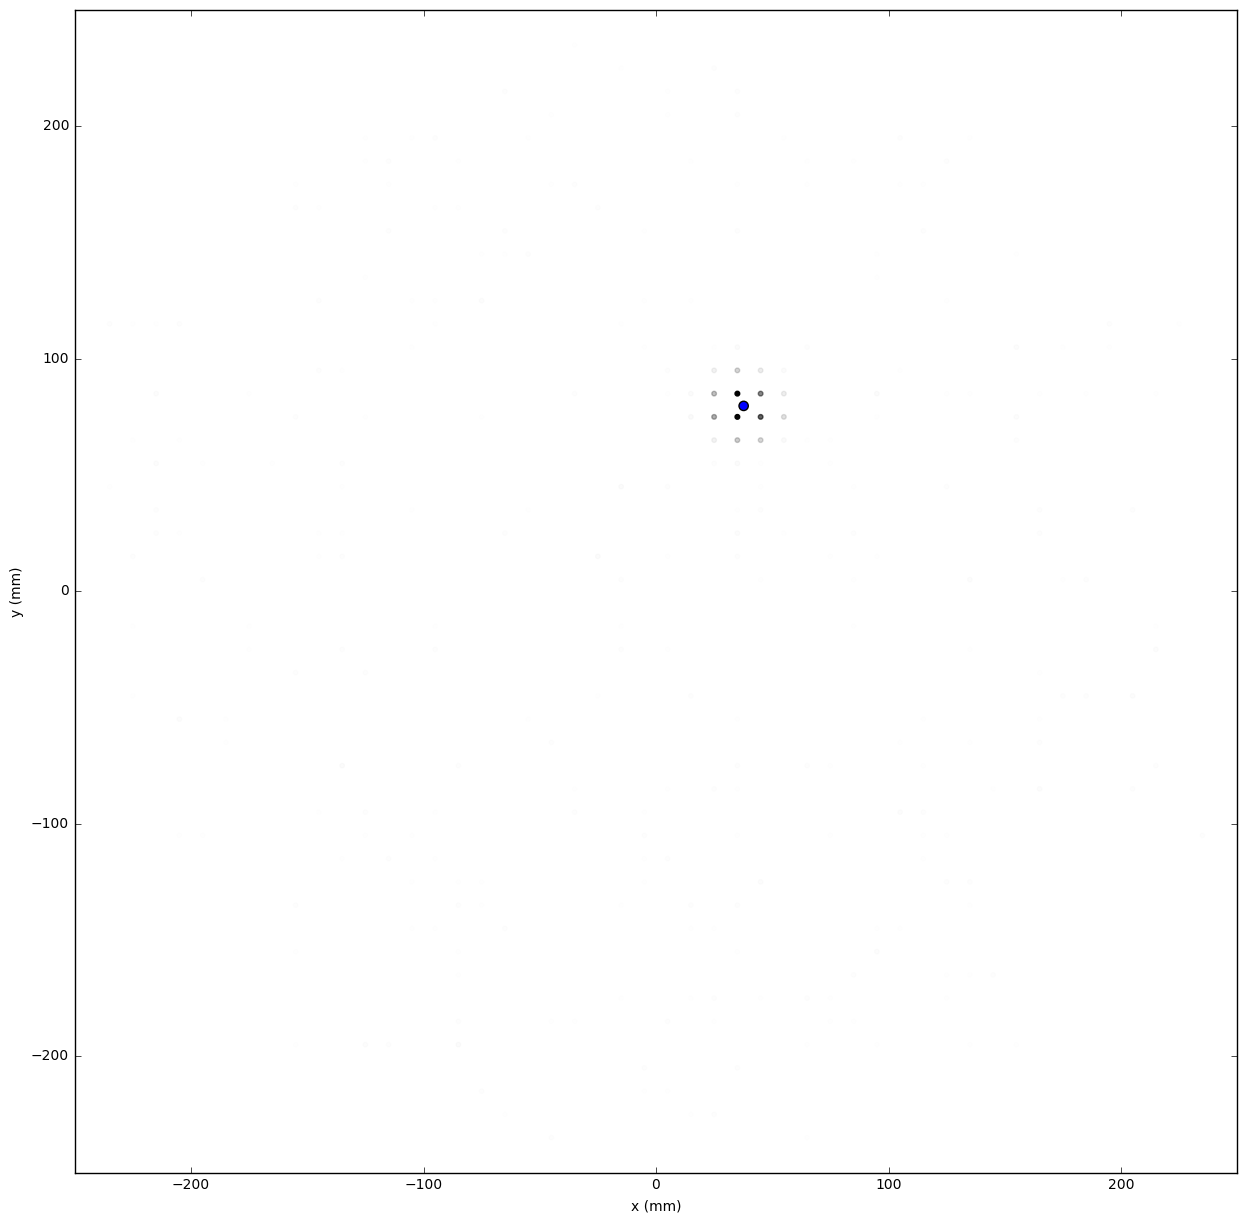

In [2]:
indata = tb.open_file('NEW_training_diff_MC_1pt5M.h', 'r')
maps = np.reshape(indata.root.maps,(len(indata.root.maps), 48 ,48))
lbl = np.array(indata.root.coords,dtype=np.float32)
pevt = np.random.randint(len(lbl))
fig = plt.figure();
ax1 = fig.add_subplot(111);
fig.set_figheight(15.0)
fig.set_figwidth(15.0)
ax1.axis([-250, 250, -250, 250]);

xarr = maps[pevt]
yarr = lbl[pevt, :2]

def NEW_SiPM_map_plot(xarr, yarr, plot_truth=True, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    for i in range(48):
        for j in range(48):
            r = Ellipse(xy=(i * 10 - 235, j * 10 - 235), width=2., height=2.);
            r.set_facecolor('0');
            r.set_alpha(probs[i, j]);
            ax1.add_artist(r);
            
    if plot_truth:
        # Place a large blue circle for actual EL points.
        xpt = yarr[0]
        ypt = yarr[1]
        mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
        mrk.set_facecolor('b');
        ax1.add_artist(mrk);
        #print(xpt,ypt)

NEW_SiPM_map_plot(xarr, yarr)        
    
# Show the plot.
plt.xlabel("x (mm)");
plt.ylabel("y (mm)");
#plt.show()

In [34]:
x      = np.reshape(indata.root.maps,(len(indata.root.maps),1,48,48)) # for cnn
print(np.mean(x),np.std(x), np.min(x),np.max(x))
x     /= np.max(x)
print(np.min(x),np.max(x))
y_  = np.array(indata.root.coords[:,:2],dtype=np.float32)
y_ /= 198.0
y_ += 1
y_ /= 2.0
z   = np.array(indata.root.coords[:, 2],dtype=np.float32)

0.58699 8.95314 0.0 1106.11
0.0 1.0


In [33]:
print(z[:10])

[  40.68187714  252.70852661  257.51489258  375.05947876  386.54858398
  328.39416504  253.29171753  211.62117004  203.48123169  355.7767334 ]


Setup DNN

In [4]:
model = Sequential()
#model.add(MaxPooling2D(pool_size=(2,2), input_shape=(1,48,48)))
#model.add(Convolution2D(16,1,1, border_mode='same', input_shape=(1,48,48)))
#model.add(Convolution2D(64,3,3, border_mode='valid',input_shape=(1,48,48)))
model.add(Flatten(input_shape=(1,48,48)))
#model.add(Flatten())
model.add(Dense(output_dim=1024,activation='relu')) 
model.add(Dense(output_dim=512,  activation='relu'))
model.add(Dense(output_dim=256,  activation='relu'))
model.add(Dense(output_dim=128, activation='relu'))
#model.add(Dense(output_dim=64, activation='relu'))
model.add(Dense(output_dim=2,    activation='relu'))
#model.compile(loss='mse', optimizer=SGD(lr=0.0001, momentum=0.9, nesterov=True))
#model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
model.compile(loss='mse', optimizer=Nadam(lr=0.0008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=4))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 2304)          0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          2360320     flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           524800      dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 256)           131328      dense_2[0][0]                    
___________________________________________________________________________________________

In [5]:
ntrain = 1400000
epochs = 100
xtr    = x [:ntrain]
xv     = x [ntrain:]
ytr    = y_[:ntrain]
yv     = y_[ntrain:]
zv     = z[ntrain:]
#callbacks = [ReduceLROnPlateau(moniter='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]
hist   = model.fit(xtr, ytr, nb_epoch=epochs, batch_size=1000, validation_data=(xv,yv), verbose=2, callbacks=[])

Train on 1400000 samples, validate on 98980 samples
Epoch 1/100
27s - loss: 0.0014 - val_loss: 7.5733e-05
Epoch 2/100
28s - loss: 9.6956e-05 - val_loss: 4.0754e-05
Epoch 3/100
27s - loss: 5.5262e-05 - val_loss: 2.0771e-05
Epoch 4/100
27s - loss: 3.8066e-05 - val_loss: 5.5517e-06
Epoch 5/100
27s - loss: 2.7383e-05 - val_loss: 1.0875e-05
Epoch 6/100
28s - loss: 1.8750e-05 - val_loss: 1.1242e-05
Epoch 7/100
28s - loss: 1.5605e-05 - val_loss: 2.7084e-05
Epoch 8/100
27s - loss: 1.2489e-05 - val_loss: 3.6025e-05
Epoch 9/100
28s - loss: 9.8672e-06 - val_loss: 1.7116e-05
Epoch 10/100
27s - loss: 9.1950e-06 - val_loss: 1.8722e-06
Epoch 11/100
27s - loss: 7.5842e-06 - val_loss: 1.2482e-05
Epoch 12/100
28s - loss: 6.6212e-06 - val_loss: 9.8976e-06
Epoch 13/100
28s - loss: 6.2545e-06 - val_loss: 2.8253e-06
Epoch 14/100
27s - loss: 5.4936e-06 - val_loss: 1.5426e-06
Epoch 15/100
27s - loss: 5.3163e-06 - val_loss: 3.7738e-06
Epoch 16/100
28s - loss: 4.8160e-06 - val_loss: 3.9599e-06
Epoch 17/100
28s 

In [28]:
predictions = np.array(model.predict(xv))
dist = np.sqrt((predictions[:, 0] - yv[:, 0])**2 + (predictions[:, 1] - yv[:, 1])**2) * 396
print(np.mean(dist))

0.500579


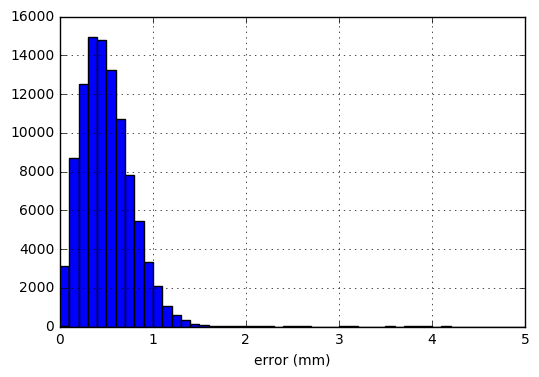

In [7]:
plt.hist(dist,50,(0,5))
plt.grid(True)
plt.xlabel('error (mm)')
plt.show()

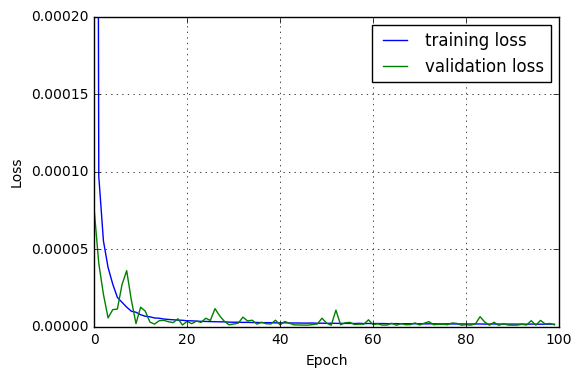

In [8]:
plt.plot(range(epochs), hist.history['loss'],     label='training loss')
plt.plot(range(epochs), hist.history['val_loss'], label='validation loss')
plt.ylim([0,.0002])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

/usr/local/lib/python2.7/dist-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


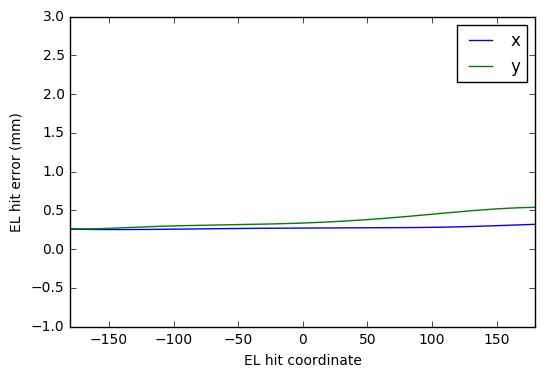

In [9]:
def plot_coord_error(predictions, labels):
    """
    Plot error as a function of coordinate 
    """
    gpredictions = (predictions*2 - 1)*198
    gyv          = (labels     *2 - 1)*198

    xerr = abs(gpredictions[:,0] - gyv[:,0])
    yerr = abs(gpredictions[:,1] - gyv[:,1])
    
    # could replace these best fit lines with something average data points
    # x, y error as a function of x, y  EL hit coordinate
    order = 8
    bestfitx = plt.plot(np.unique(gyv[:,0]), np.poly1d(np.polyfit(gyv[:,0],xerr, order))(np.unique(gyv[:,0])),label='x')
    bestfitx = plt.plot(np.unique(gyv[:,1]), np.poly1d(np.polyfit(gyv[:,1],yerr, order))(np.unique(gyv[:,1])),label='y')
    plt.legend(loc='upper right')
    plt.xlabel('EL hit coordinate')
    plt.ylabel('EL hit error (mm)')
    plt.xlim(-180,180)
    plt.ylim(-1, 3)
    plt.show()

    
plot_coord_error(yv,predictions)

0.487263 [-154.80982971  -43.97233582] [-154.54077148  -44.37857437]


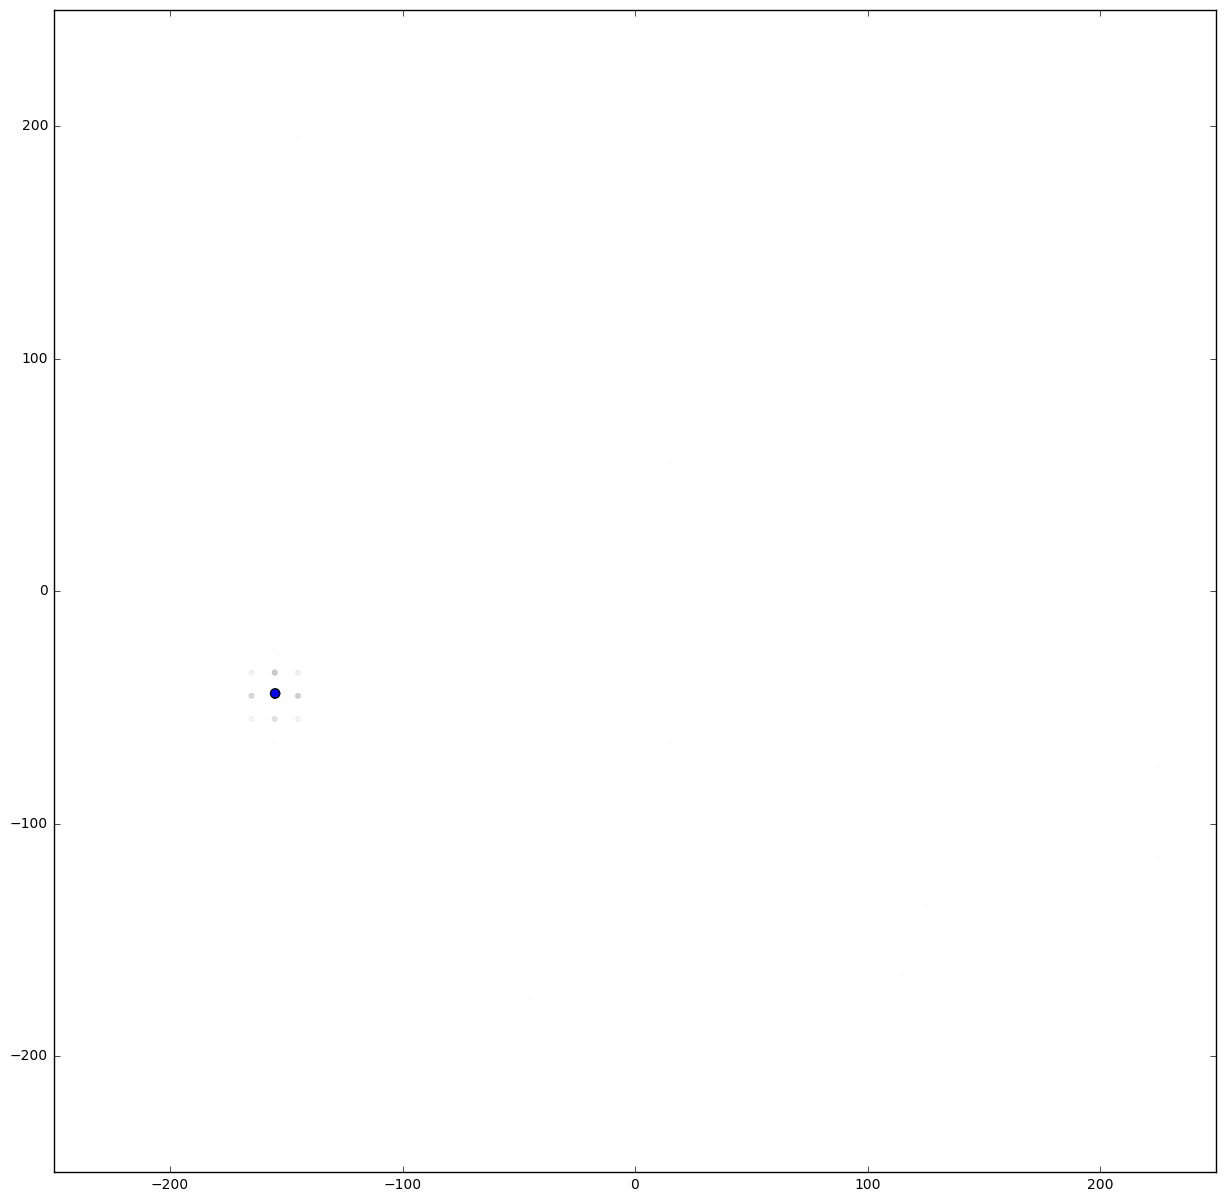

In [10]:
ex_pred = np.random.randint(len(xv))

print(dist[ex_pred],(2*predictions[ex_pred]-1)*198,(2*yv[ex_pred]-1)*198)
fig = plt.figure();
ax1 = fig.add_subplot(111);
fig.set_figheight(15.0)
fig.set_figwidth(15.0)
ax1.axis([-250, 250, -250, 250])

NEW_SiPM_map_plot(np.reshape(xv[ex_pred],(48,48)), (2*predictions[ex_pred]-1)*198)     
plt.show()

/usr/local/lib/python2.7/dist-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


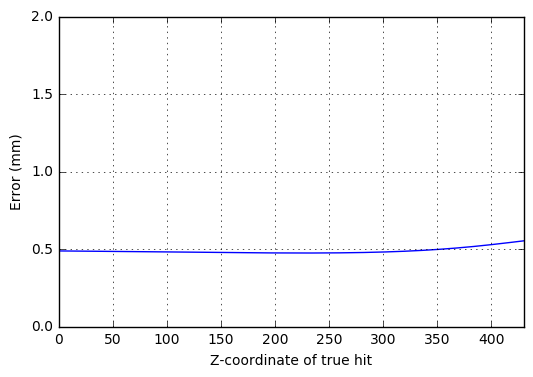

/usr/local/lib/python2.7/dist-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


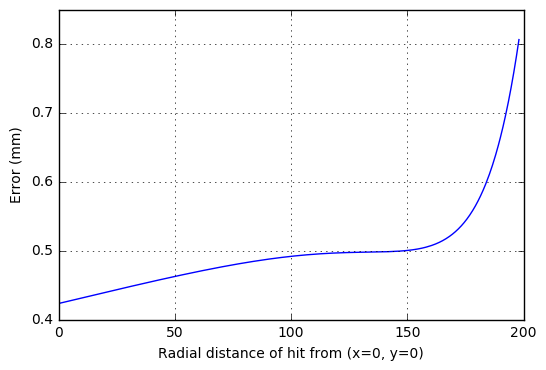

In [37]:
def error_z_plot(error, z):
    """
    error_z_plot plots error as a function of z coordinate. Diffusion and no diffusion
    """
    order = 50
    bestfit = plt.plot(np.unique(z), np.poly1d(np.polyfit(z,error, order))(np.unique(z)))
    plt.ylim(0,2)
    plt.xlim(0,430)
    plt.xlabel('Z-coordinate of true hit')
    plt.ylabel('Error (mm)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

def error_rad_plot(error, label):
    """
    error_rad_plot plots error as a function of radial difference from (x=0, y=0)
    of the actual position of the hit. Diffusion and no diffusion
    """
    lab = (label*2 - 1)*198
    rad = np.sqrt(lab[:,0]**2 + lab[:,1]**2)
    order = 50
    bestfit = plt.plot(np.unique(rad), np.poly1d(np.polyfit(rad, error, order))(np.unique(rad)))
    plt.grid(True)
    plt.xlabel('Radial distance of hit from (x=0, y=0)')
    plt.ylabel('Error (mm)')
    plt.legend(loc='upper left')
    plt.show()

error_z_plot(dist, zv)
error_rad_plot(dist, yv)